# Load and plot iris

X: [[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]]
y: [0 0 0 0 0]


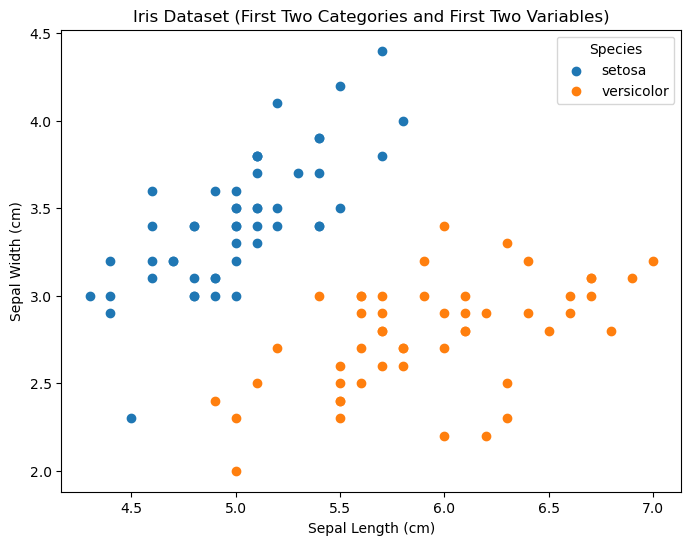

In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd

# Load the iris dataset
iris = datasets.load_iris()

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = iris.target

# Filter for only the first two species (target 0 and 1) and the first two features
filtered_df = df[df['species'] < 2].iloc[:, [0, 1, 4]]

# Separate features and target into X and y
X = filtered_df.iloc[:, [0, 1]].values  # First two features as a numpy array
y = filtered_df['species'].values       # Species as a numpy array

# Now X and y are ready for further processing or plotting
print("X:", X[:5])  # Display first 5 rows of X for confirmation
print("y:", y[:5])  # Display first 5 elements of y for confirmation

# Plot the data
plt.figure(figsize=(8, 6))
for species in set(y):
    plt.scatter(X[y == species, 0], X[y == species, 1], label=iris.target_names[species])

# Add plot labels and legend
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.legend(title='Species')
plt.title('Iris Dataset (First Two Categories and First Two Variables)')
plt.show()


/home/javi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy: 0.99
Cross-Entropy Loss: 0.343700186454351


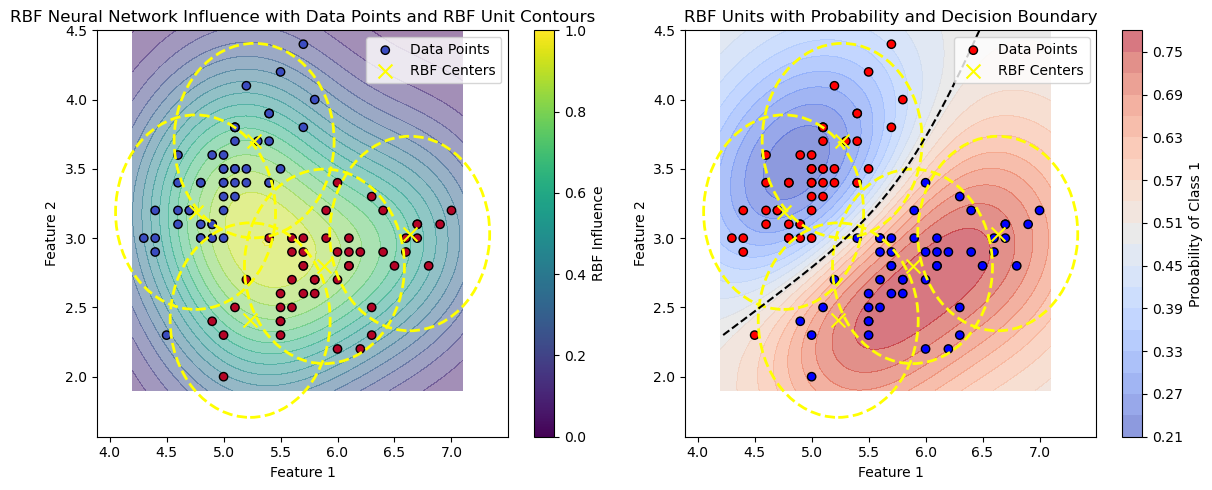

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle

# RBF Code adapted from 
# https://www.geeksforgeeks.org/what-are-radial-basis-function-neural-networks/
# Generate sample data (binary classification problem)
#np.random.seed(0)
#X = np.random.rand(100, 2)
#y = (np.sin(X[:, 0]) + np.cos(X[:, 1]) > 1).astype(int)  # Binary labels: 0 or 1

# Try changing this
n_rbfs = 5
# Try changing this
draw_circles = True

# Define the radial basis function
def rbf(x, c, s):
    return np.exp(-np.linalg.norm(x - c) ** 2 / (2 * s ** 2))

# Choose centers using k-means
kmeans = KMeans(n_clusters=n_rbfs).fit(X)
centers = kmeans.cluster_centers_

# Calculate the spread parameter
d_max = np.max(cdist(centers, centers, 'euclidean'))
# Try changing this
sigma = d_max / np.sqrt(2 * len(centers)) 

# Calculate effective radius for each RBF unit
rbf_radius = sigma * np.sqrt(-2 * np.log(0.5))

# Define the RBF network with softmax
def rbf_network_with_softmax(X, centers, sigma, W):
    R = np.zeros((X.shape[0], len(centers)))
    for i in range(X.shape[0]):
        for j in range(len(centers)):
            R[i, j] = rbf(X[i], centers[j], sigma)
    
    # Linear output before softmax
    linear_output = np.dot(R, W)
    
    # Apply softmax
    exp_output = np.exp(linear_output - np.max(linear_output, axis=1, keepdims=True))
    probabilities = exp_output / np.sum(exp_output, axis=1, keepdims=True)
    
    return probabilities

# One-hot encode the labels
y_one_hot = np.zeros((y.size, 2))
y_one_hot[np.arange(y.size), y] = 1

# Compute the output weights for both classes
R = np.zeros((X.shape[0], len(centers)))
for i in range(X.shape[0]):
    for j in range(len(centers)):
        R[i, j] = rbf(X[i], centers[j], sigma)
        
W = np.dot(np.linalg.pinv(R), y_one_hot)

# Create a mesh grid for plotting
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Compute the RBF influence for each grid point
Z_influence = np.zeros((xx.shape[0], xx.shape[1], len(centers)))
for i in range(len(centers)):
    for j in range(xx.shape[0]):
        for k in range(xx.shape[1]):
            Z_influence[j, k, i] = rbf(np.array([xx[j, k], yy[j, k]]), centers[i], sigma)
Z_sum_influence = np.sum(Z_influence, axis=2)

# Compute the probability output for each grid point
grid_points = np.c_[xx.ravel(), yy.ravel()]
probs = rbf_network_with_softmax(grid_points, centers, sigma, W)
Z_probs = probs[:, 1].reshape(xx.shape)  # Probability of class 1



from sklearn.metrics import accuracy_score, log_loss
# Make predictions (get probabilities for both classes)
y_pred_probs = rbf_network_with_softmax(X, centers, sigma, W)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluate the model
accuracy = accuracy_score(y, y_pred)
cross_entropy_loss = log_loss(y, y_pred_probs)

print(f"Accuracy: {accuracy}")
print(f"Cross-Entropy Loss: {cross_entropy_loss}")



# Plot 1: RBF Influence with Data Points and RBF Unit Contours
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z_sum_influence, levels=20, cmap='viridis', alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='yellow', marker='x', label='RBF Centers')

if draw_circles: 
    # Draw circles representing the radius of each RBF unit
    for center in centers:
        circle = Circle(center, rbf_radius, color='yellow', fill=False, linestyle='--', linewidth=2)
        plt.gca().add_patch(circle)

plt.colorbar(label="RBF Influence")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('RBF Neural Network Influence with Data Points and RBF Unit Contours')
plt.legend()

# Plot 2: RBF Units with Probability Assigned to Each Data Point and Decision Boundary
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z_probs, levels=20, cmap='coolwarm', alpha=0.6)
plt.colorbar(label="Probability of Class 1")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['red', 'blue']), edgecolor='k', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='yellow', marker='x', label='RBF Centers')

if draw_circles: 
    # Draw circles representing the radius of each RBF unit
    for center in centers:
        circle = Circle(center, rbf_radius, color='yellow', fill=False, linestyle='--', linewidth=2)
        plt.gca().add_patch(circle)

# Decision boundary
plt.contour(xx, yy, Z_probs, levels=[0.5], colors='black', linestyles='--')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('RBF Units with Probability and Decision Boundary')
plt.legend()

plt.tight_layout()
plt.show()